In [20]:
import pandas as pd
import numpy as np
import optuna
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.feature_selection import SelectFdr, f_classif
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [43]:
clean_df = pd.read_csv('/Users/serenaliu/Documents/GitHub/FoodReceipeNLP/data/cleaned_data.csv')
test_df = pd.read_csv('/Users/serenaliu/Documents/GitHub/FoodReceipeNLP/data/test_data.csv')

# Model Implementation 

### Feature normalization and feature selection on training data

In [44]:
X = clean_df.iloc[:,:-1]
y = clean_df['Cuisine']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Feature filtering using false positive rate
fdr = SelectFdr(score_func = f_classif, alpha = 0.01)
fdr.fit(X, y)
X_fdr = fdr.transform(X)

# Check the number of features and the names of features selected by fdr
feat_labels = list(clean_df.columns)
i = 0
selected_labels = list()
for feature_list_index in fdr.get_support(indices = True):
    i += 1
    selected_labels.append(clean_df.columns.get_loc(feat_labels[feature_list_index]))
#    print(feat_labels[feature_list_index])
print('Number of features selected: ',i)


# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_fdr, y, test_size=0.2, random_state=42)

Number of features selected:  160


### Feature selection on out of sample data

In [45]:
X_outsample = test_df.iloc[:,:-1]
y_outsample = test_df['Cuisine']

scaled_X_outsample = scaler.fit_transform(X_outsample)

# Remove the same columns that was removed by the FDS process on training data
remove_labels = []
i = 0
while i < len(X_outsample.columns):
    if i  in selected_labels: i += 1
    else:
        remove_labels.append(i)
        i += 1
    
scaled_X_outsample = np.delete(scaled_X_outsample, remove_labels, axis=1)

### KNN

In-sample F1 score of KNN : 0.413
In-sample testing accuracy of KNN : 0.397 
Out-sample F1 score of KNN : 0.050
Out-sample testing accuracy of KNN : 0.057 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


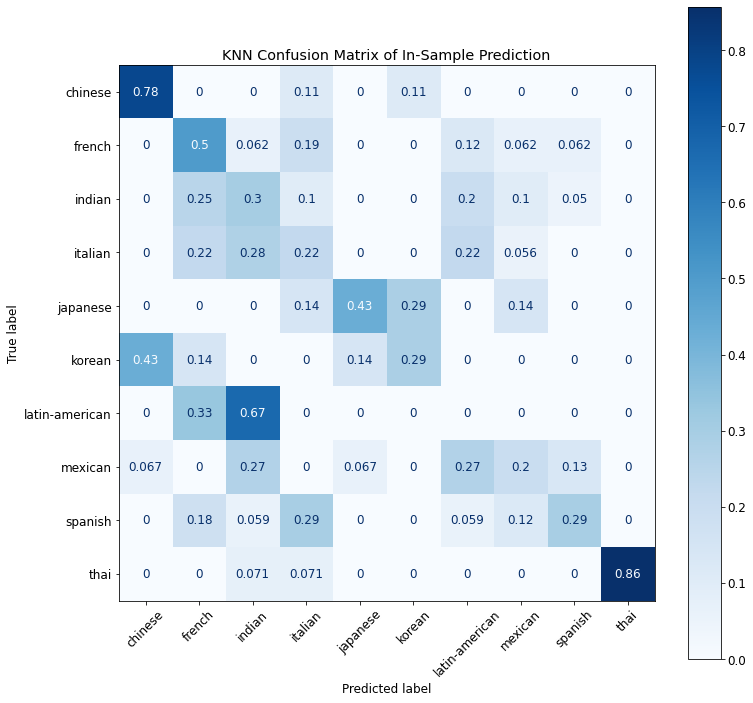

In [46]:
knn =  KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_outsample_pred = knn.predict(scaled_X_outsample)

print('In-sample F1 score of KNN : %.3f' % f1_score(y_test, y_pred, average='weighted'))
print('In-sample testing accuracy of KNN : %.3f ' % accuracy_score(y_test, y_pred))
print('Out-sample F1 score of KNN : %.3f' % f1_score(y_outsample, y_outsample_pred, average='weighted'))
print('Out-sample testing accuracy of KNN : %.3f ' % accuracy_score(y_outsample, y_outsample_pred))

fig, ax = plt.subplots(figsize=(12, 12))
plt.rcParams.update({'font.size': 12})
ax.set_title('KNN Confusion Matrix of In-Sample Prediction')
plot_confusion_matrix(knn, X_test, y_test, ax=ax, xticks_rotation=45, cmap=plt.cm.Blues, normalize='true')  
plt.savefig('/Users/serenaliu/Documents/GitHub/FoodReceipeNLP/plot/knn.png')
plt.show()

### SVM

In-sample F1 score of SVC : 0.600
In-sample testing accuracy of SVC : 0.595 
Out-sample F1 score of SVC : 0.036
Out-sample testing accuracy of SVC : 0.029 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


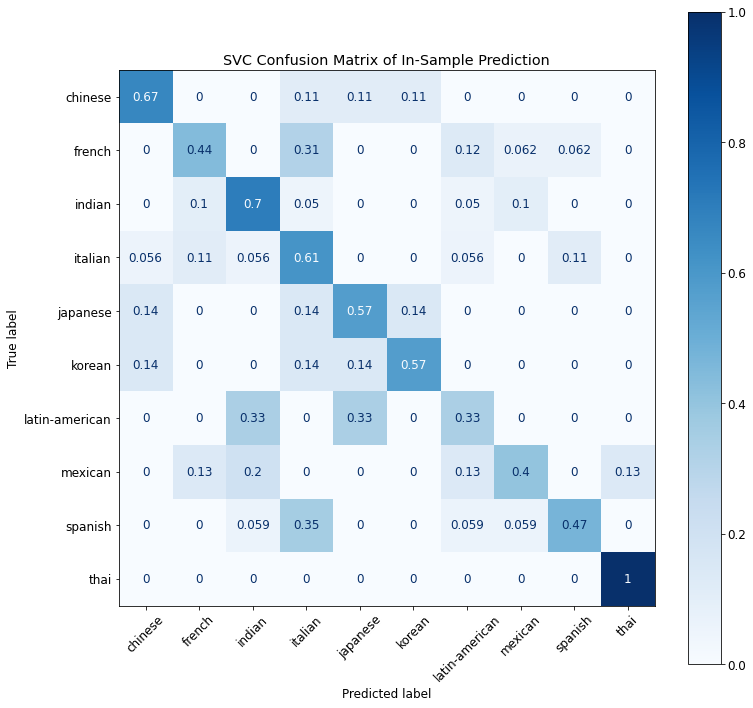

In [47]:
svc = SVC(C=1000, gamma=0.0001, kernel='rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_outsample_pred = svc.predict(scaled_X_outsample)

print('In-sample F1 score of SVC : %.3f' % f1_score(y_test, y_pred, average='weighted'))
print('In-sample testing accuracy of SVC : %.3f ' % accuracy_score(y_test, y_pred))
print('Out-sample F1 score of SVC : %.3f' % f1_score(y_outsample, y_outsample_pred, average='weighted'))
print('Out-sample testing accuracy of SVC : %.3f ' % accuracy_score(y_outsample, y_outsample_pred))

fig, ax = plt.subplots(figsize=(12, 12))
plt.rcParams.update({'font.size': 12})
ax.set_title('SVC Confusion Matrix of In-Sample Prediction')
plot_confusion_matrix(svc, X_test, y_test, ax=ax, xticks_rotation=45, cmap=plt.cm.Blues, normalize='true')  
plt.savefig('/Users/serenaliu/Documents/GitHub/FoodReceipeNLP/plot/svm.png')
plt.show()

In [48]:
# Hyperparameter tuning
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly', 'sigmoid']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model using grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.120 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.130 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.130 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.130 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.130 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.380 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.310 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.290 total time=   0.0s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.360 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.430 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.150 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid

[CV 5/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.390 total time=   0.0s
[CV 1/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.270 total time=   0.0s
[CV 2/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.250 total time=   0.0s
[CV 3/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.240 total time=   0.0s
[CV 4/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.310 total time=   0.0s
[CV 5/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.290 total time=   0.0s
[CV 1/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.270 total time=   0.0s
[CV 2/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.230 total time=   0.0s
[CV 3/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.210 total time=   0.0s
[CV 4/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.280 total time=   0.0s
[CV 5/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.210 total time=   0.0s
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.250 total time=   0.0s
[CV 2/5] END ......C=1, gamm

[CV 4/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.280 total time=   0.0s
[CV 5/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.270 total time=   0.0s
[CV 1/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.110 total time=   0.0s
[CV 2/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.130 total time=   0.0s
[CV 3/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.130 total time=   0.0s
[CV 4/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.130 total time=   0.0s
[CV 5/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.130 total time=   0.0s
[CV 1/5] END C=10, gamma=0.0001, kernel=sigmoid;, score=0.140 total time=   0.0s
[CV 2/5] END C=10, gamma=0.0001, kernel=sigmoid;, score=0.180 total time=   0.0s
[CV 3/5] END C=10, gamma=0.0001, kernel=sigmoid;, score=0.200 total time=   0.0s
[CV 4/5] END C=10, gamma=0.0001, kernel=sigmoid;, score=0.190 total time=   0.0s
[CV 5/5] END C=10, gamma=0.0001, kernel=sigmoid;, score=0.230 total time=   0.0s
[CV 1/5] END ........C=100, 

[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.210 total time=   0.0s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.250 total time=   0.0s
[CV 1/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.380 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.310 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.290 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.360 total time=   0.0s
[CV 5/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.430 total time=   0.0s
[CV 1/5] END .C=1000, gamma=0.1, kernel=sigmoid;, score=0.240 total time=   0.0s
[CV 2/5] END .C=1000, gamma=0.1, kernel=sigmoid;, score=0.150 total time=   0.0s
[CV 3/5] END .C=1000, gamma=0.1, kernel=sigmoid;, score=0.180 total time=   0.0s
[CV 4/5] END .C=1000, gamma=0.1, kernel=sigmoid;, score=0.280 total time=   0.0s
[CV 5/5] END .C=1000, gamma=0.1, kernel=sigmoid;, score=0.150 total time=   0.0s
[CV 1/5] END ....C=1000, gam

### Random Forest

In-sample F1 score of Random Forest : 0.512
In-sample testing accuracy of Random Forest : 0.524 
Out-sample F1 score of Random Forest : 0.018
Out-sample testing accuracy of Random Forest : 0.029 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


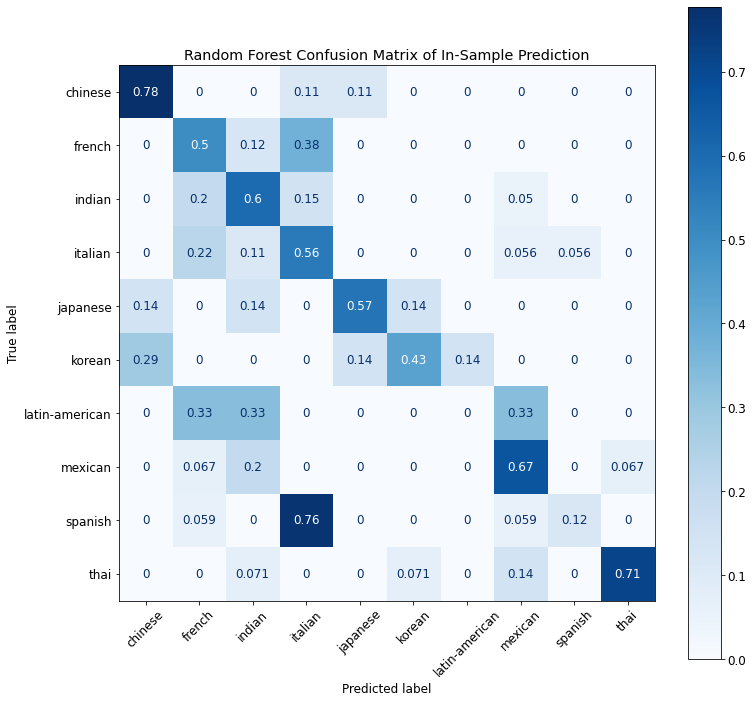

In [37]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=7, min_samples_leaf=4)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_outsample_pred = rfc.predict(scaled_X_outsample)

print('In-sample F1 score of Random Forest : %.3f' % f1_score(y_test, y_pred, average='weighted'))
print('In-sample testing accuracy of Random Forest : %.3f ' % accuracy_score(y_test, y_pred))
print('Out-sample F1 score of Random Forest : %.3f' % f1_score(y_outsample, y_outsample_pred, average='weighted'))
print('Out-sample testing accuracy of Random Forest : %.3f ' % accuracy_score(y_outsample, y_outsample_pred))

fig, ax = plt.subplots(figsize=(12, 12))
plt.rcParams.update({'font.size': 12})
ax.set_title('Random Forest Confusion Matrix of In-Sample Prediction')
plot_confusion_matrix(rfc, X_test, y_test, ax=ax, xticks_rotation=45, cmap=plt.cm.Blues, normalize='true')  
plt.savefig('/Users/serenaliu/Documents/GitHub/FoodReceipeNLP/plot/rfc.png')
plt.show()

### CatBoost

Learning rate set to 0.5
0:	learn: 2.1822034	total: 31.6ms	remaining: 1.55s
1:	learn: 2.0397779	total: 62ms	remaining: 1.49s
2:	learn: 1.9684064	total: 91.6ms	remaining: 1.44s
3:	learn: 1.8466137	total: 121ms	remaining: 1.4s
4:	learn: 1.7183037	total: 154ms	remaining: 1.39s
5:	learn: 1.6226721	total: 186ms	remaining: 1.36s
6:	learn: 1.5615973	total: 224ms	remaining: 1.38s
7:	learn: 1.5135744	total: 260ms	remaining: 1.37s
8:	learn: 1.4658849	total: 290ms	remaining: 1.32s
9:	learn: 1.4097258	total: 320ms	remaining: 1.28s
10:	learn: 1.3390773	total: 352ms	remaining: 1.25s
11:	learn: 1.2645204	total: 383ms	remaining: 1.21s
12:	learn: 1.2086936	total: 414ms	remaining: 1.18s
13:	learn: 1.1530329	total: 447ms	remaining: 1.15s
14:	learn: 1.0949641	total: 477ms	remaining: 1.11s
15:	learn: 1.0444039	total: 507ms	remaining: 1.08s
16:	learn: 0.9819776	total: 538ms	remaining: 1.04s
17:	learn: 0.9404413	total: 569ms	remaining: 1.01s
18:	learn: 0.8822192	total: 600ms	remaining: 979ms
19:	learn: 0.832

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


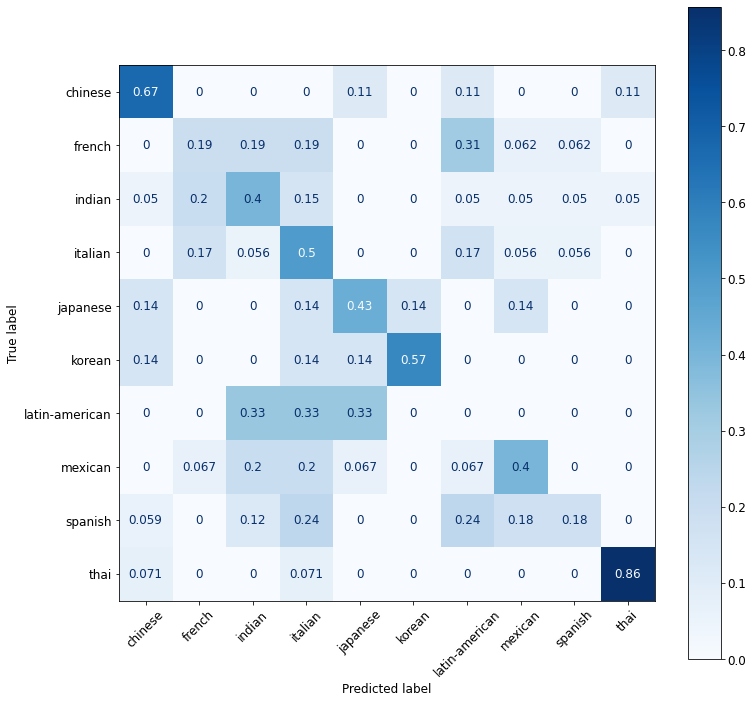

In [49]:
catboost = CatBoostClassifier(iterations=50)
catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_test)
y_outsample_pred = catboost.predict(scaled_X_outsample)

print('In-sample F1 score of CatBoost: %.3f' % f1_score(y_test, y_pred, average='weighted'))
print('In-sample testing accuracy of CatBoost: %.3f ' % accuracy_score(y_test, y_pred))
print('Out-sample F1 score of CatBoost: %.3f' % f1_score(y_outsample, y_outsample_pred, average='weighted'))
print('Out-sample testing accuracy of CatBoost: %.3f ' % accuracy_score(y_outsample, y_outsample_pred))

fig, ax = plt.subplots(figsize=(12, 12))
plt.rcParams.update({'font.size': 12})
plot_confusion_matrix(catboost, X_test, y_test, ax=ax, xticks_rotation=45, cmap=plt.cm.Blues, normalize='true')  
plt.savefig('/Users/serenaliu/Documents/GitHub/FoodReceipeNLP/plot/catboost.png')
plt.show()

# Cosine similarity measures

Combine the predicted labels in the test set with the original dataset that we obtained from web crawling.

In [39]:
recipe_df = pd.read_csv('/Users/serenaliu/Documents/GitHub/FoodReceipeNLP/data/all_recipes.csv')
X_raw = recipe_df.iloc[:,:-1]
y_raw = recipe_df['Cuisine']
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

X_test_raw = X_test_raw.reset_index(drop=True)
true_label = pd.Series.to_frame(y_test_raw)
true_label = true_label.reset_index(drop=True)

test_df = pd.merge(X_test_raw, true_label, left_index=True, right_index=True)

In [40]:
# Reference: https://newscatcherapi.com/blog/ultimate-guide-to-text-similarity-with-python
def word_vectorizer(lst):
    '''
    Convert a list of texts to a matrix of token counts
    '''
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(lst)
    arr = X.toarray()
    return arr

def create_heatmap(similarity, col_names, filename, cmap = plt.cm.Blues,):
    '''
    Create a heatmap to visualise cosine similarity 
    '''
    df = pd.DataFrame(similarity)
    df.columns = col_names
    df.index = col_names
    
    fig, ax = plt.subplots(figsize=(6.5,6.5))
    ax.figure.tight_layout() 
    png = sns.heatmap(df, annot = True, cmap=cmap)
    png.set_xticklabels(png.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.figure.savefig('/Users/serenaliu/Documents/GitHub/FoodReceipeNLP/plot/' + filename + '.png', 
                      transparent=True, bbox_inches='tight')
    return f'Heatmap produced'

### Similarity between Latin-American and Indian cuisine

Looking at the prediction result given by our best classifier, SVM, around 33% of the Latin-American food is misclassified as Indian food. In addition, Random Forest classifier classified 67% of the Latin-American food as Indian food. Therefore, we would like to find out the similarity between ingredients used by these two cuisines. Since there are only 3 instances under the Latin-American category, we will randomly sample 3 instances from the Indian category as comparison.

'Heatmap produced'

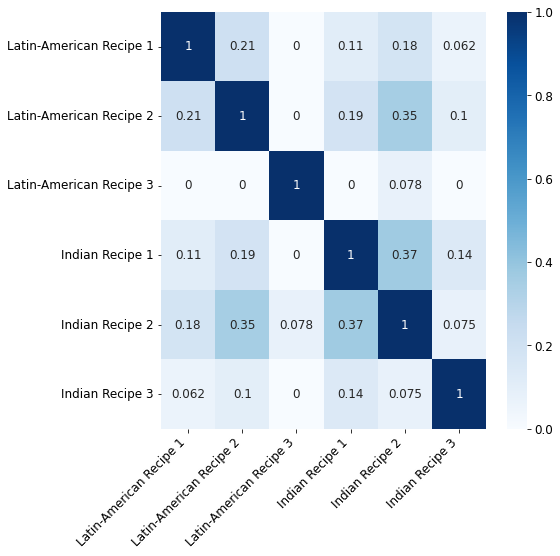

In [41]:
# Selec a subset of dataframe for comparison
latin_american = test_df[test_df['Cuisine'] == 'latin-american']
indian = test_df[test_df['Cuisine'] == 'indian'].sample(n=3, random_state=42)
latin_ingre_lst = latin_american['Ingredients'].tolist()
indian_ingre_lst = indian['Ingredients'].tolist()
lst_1 = latin_ingre_lst + indian_ingre_lst

vec_1 = word_vectorizer(lst_1)
columns = ['Latin-American Recipe 1', 'Latin-American Recipe 2', 'Latin-American Recipe 3', 
           'Indian Recipe 1', 'Indian Recipe 2','Indian Recipe 3',]
create_heatmap(cosine_similarity(vec_1), columns, 'latin_indian_similarity')

### Similarity between Chinese and Japenese cuisine

Looking at the prediction result given by SVM, 22% of the Chinese food is misclassified as Janpanese food (11% by CatBoost), so we would like to find out the similarity between ingredients used by these two cuisines. We will randomly sample 3 instances from the these two categories as comparison.

'Heatmap produced'

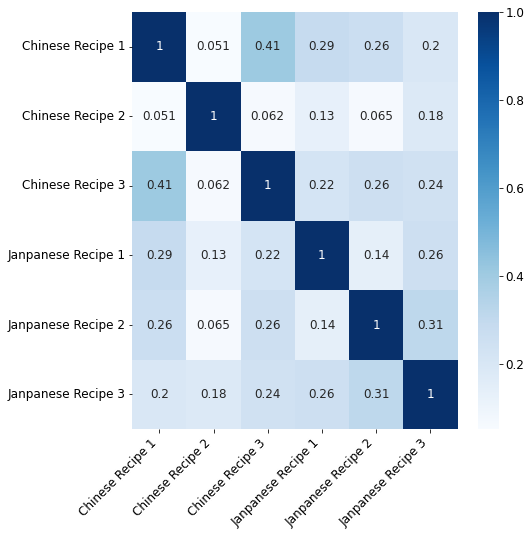

In [42]:
chinese = test_df[test_df['Cuisine'] == 'chinese'].sample(n=3, random_state=0)
japanese = test_df[test_df['Cuisine'] == 'japanese'].sample(n=3, random_state=0)
chinese_ingre_lst = chinese['Ingredients'].tolist()
japanese_ingre_lst = japanese['Ingredients'].tolist()
lst_2 = chinese_ingre_lst + japanese_ingre_lst

vec_2 = word_vectorizer(lst_2)
columns = ['Chinese Recipe 1', 'Chinese Recipe 2', 'Chinese Recipe 3', 
           'Janpanese Recipe 1', 'Janpanese Recipe 2','Janpanese Recipe 3',]
create_heatmap(cosine_similarity(vec_2), columns, 'chinese_japanese_similarity')